In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#%matplotlib inline  # Configurations


In [3]:
# Configurations
# 3 Servers
# 3 Client VMs
# 2 Memtier instances per VM
# CT=1
# 2 Middlewares
wt = [8, 16, 32, 64] 
vc = [1, 4, 8, 16, 24, 32, 40]
figure_path = "/home/simon/eth/asl-fall17-project/report/Data/41/"

In [4]:
# 4.1 Full System Write Throughput
data_path = "/home/simon/eth/asl-fall17-project/experiment-scripts/4_throughput_for_writes/41_full_system/logs/"


mw1_sets_tp = {}
mw1_sets_rt = {}

mw2_sets_tp = {}
mw2_sets_rt = {}

avgQTimes = []
avgQLengths = [] 
avgServiceTimes = []
max_tps = []

for threads in wt:
    qtimes = []
    qlengths = []
    servicetimes = []
    max_tp = 0
    for clients in vc:
        qtimesum = 0
        qlengthsum = 0
        servicetimesum = 0
        denom = 0
        # SETS
        path = data_path+"/wt"+str(threads)+"/VC_"+str(clients)+"/SETS/"
        for directory, subdirectory, files in os.walk(path):
            if(subdirectory == ['MW2', 'MW1']):
                # MW1
                for directory, subdirectory, files in os.walk(path+"MW1/"):
                    if(len(files) == 4 ):
                        # We're in a MW folder
                        table = pd.read_csv(directory+"/MeasurementTable.csv",index_col=False)
                        rt_histogram = pd.read_csv(directory+"/ResponseTimeHistogram.csv")
                        throughput = np.sum(table['set'][1:])/np.max(table['time'])/threads
                        resptime = 0
                        total_count = 0
                        
                        qtimesum += np.sum(table['avgWaitingTime'][2:])
                        qlengthsum += np.sum(table['avgQueueLength'][2:])
                        servicetimesum += np.sum(table['avgSetServiceTime'][2:])
                        denom += len(table['avgSetServiceTime'][2:])
                        

                        for row in range(rt_histogram.shape[0]):
                            total_count += rt_histogram.iloc[row,:]['requestcount']
                            resptime += rt_histogram.iloc[row,:]['requestcount']*rt_histogram.iloc[row,:]['time'] 
                        # Convert to ms from microseconds
                        resptime = resptime/total_count/1000.0

                        key = str("wt"+str(threads)+"vc"+str(clients))
                        if key not in mw1_sets_tp:
                            mw1_sets_tp[key] = []
                            mw1_sets_rt[key] = []

                        mw1_sets_tp[key].append(throughput)
                        mw1_sets_rt[key].append(resptime)
                        
                        max_tp = np.maximum(max_tp, np.max(np.divide(table['set'][1:len(table['set'])-2],4)))
                
                # MW2
                for directory, subdirectory, files in os.walk(path+"MW2/"):
                    if(len(files) ==4 ):
                        # We're in a MW folder
                        table = pd.read_csv(directory+"/MeasurementTable.csv",index_col=False)
                        rt_histogram = pd.read_csv(directory+"/ResponseTimeHistogram.csv")
                        throughput = np.sum(table['set'][1:])/np.max(table['time'])/threads
                        resptime = 0
                        total_count = 0
                        
                        qtimesum += np.sum(table['avgWaitingTime'][2:])
                        qlengthsum += np.sum(table['avgQueueLength'][2:])
                        servicetimesum += np.sum(table['avgSetServiceTime'][2:])
                        denom += len(table['avgSetServiceTime'][2:])

                        for row in range(rt_histogram.shape[0]):
                            total_count += rt_histogram.iloc[row,:]['requestcount']
                            resptime += rt_histogram.iloc[row,:]['requestcount']*rt_histogram.iloc[row,:]['time'] 
                        # Convert to ms from microseconds
                        resptime = resptime/total_count/1000.0
                        
                        key = str("wt"+str(threads)+"vc"+str(clients))
                        if key not in mw2_sets_tp:
                            mw2_sets_tp[key] = []
                            mw2_sets_rt[key] = []

                        mw2_sets_tp[key].append(throughput)
                        mw2_sets_rt[key].append(resptime)

                        max_tp = np.maximum(max_tp, np.max(np.divide(table['set'][1:len(table['set'])-2],4)))

        qtimes.append(np.divide(qtimesum, denom))
        qlengths.append(np.divide(qlengthsum, denom))
        servicetimes.append(np.divide(servicetimesum, denom))
    max_tps.append(max_tp)
    avgQTimes.append(qtimes)
    avgQLengths.append(qlengths)
    avgServiceTimes.append(servicetimes)
        
        
        
# Gather Aggregates
#8, 16, 32, 64
set_mean_tp = []
set_stddev_tp = []
set_mean_rt = []
set_stddev_rt = []

for threads in wt:
    s_m_tp = []
    s_s_tp = []
    s_m_rt = []
    s_s_rt = []
    for clients in vc:
        key = str("wt"+str(threads)+"vc"+str(clients))
        
        # Handle incomplete repetitions
        if not len(mw1_sets_tp[key]) == len(mw2_sets_tp[key]):
            print(len(mw1_sets_tp[key]))
            print(len(mw2_sets_tp[key]))
            length = np.min([len(mw1_sets_tp[key]), len(mw2_sets_tp[key])])
            mw1_sets_tp[key] = mw1_sets_tp[key][:length-1]
            mw2_sets_tp[key] = mw2_sets_tp[key][:length-1]
            print(len(mw1_sets_tp[key]))
            print(len(mw2_sets_tp[key]))
        
        s_m_tp.append(np.mean(np.add(mw1_sets_tp[key],mw2_sets_tp[key])))
        s_s_tp.append(np.std(np.add(mw1_sets_tp[key],mw2_sets_tp[key])))
        s_m_rt.append(np.mean(mw1_sets_rt[key]+mw2_sets_rt[key]))
        s_s_rt.append(np.std(mw1_sets_rt[key]+mw2_sets_rt[key]))
    
    set_mean_tp.append(s_m_tp)
    set_stddev_tp.append(s_s_tp)
    set_mean_rt.append(s_m_rt)
    set_stddev_rt.append(s_s_rt)


In [8]:
N_clients = np.multiply(3*2*1,vc)
X_axis = N_clients
table = []

print("Maximum Set Throughputs")
for i in xrange(4):
    line = ["Maximum Set Throughputs"]
    line.append(np.multiply(set_mean_tp[i],wt[i]))
    table.append(line)
    print(np.multiply(set_mean_tp[i],wt[i]))
    

print("Derived from response times")
for i in xrange(4):
    line = ["Derived from response times"]
    line.append(1000*np.divide(N_clients[6],set_mean_rt[i][6]))
    table.append(line)
    print(1000*np.divide(N_clients[6],set_mean_rt[i][6]))
print("RT")
for i in xrange(4):
    line = ["RT"]
    line.append(set_mean_rt[i])
    table.append(line)
    print(set_mean_rt[i])
print('Average Queue Times')
for i in xrange(4):
    line = ["Average Queue Times"]
    line.append(avgQTimes[i])
    table.append(line)
    print(avgQTimes[i])
print('Average Queue lengths')
for i in xrange(4):
    line = ["Average Queue Lengths"]
    line.append(avgQLengths[i][6])
    table.append(line)
    print(avgQLengths[i][6])
print("Average service times")
for i in xrange(4):
    line = ["Average service Times"]
    line.append(avgServiceTimes[i])
    table.append(line)
    print(avgServiceTimes[i])
print("Max Throughputs: ")
line = ["Max Throughputs"]
line.extend(np.multiply(max_tps,1)*2)
table.append(line)

# Write to file
import distutils.dir_util
path = "/home/simon/eth/asl-fall17-project/report/Data/41/"
p = path + "measurement_table/"
distutils.dir_util.mkpath(p)
f = open(p+"processed.log", "w+")
f.write(str(table))
f.close()

print(np.multiply(max_tps,1)*2)

Maximum Set Throughputs
[ 1485.26343966  3421.79868927  3702.93786463  3752.9481425   3775.27670942
  3778.19496091  3807.24561404]
[ 1527.42706407  3609.10663501  4537.80494958  4837.53223731  4901.17182975
  4903.10672643  4903.10674288]
[ 1526.85915835  3616.92365236  4753.46728587  5651.46619568  5884.24971386
  5926.88375982  5935.69123911]
[ 1556.98751004  3512.71993237  4650.87889103  6042.19168958  6636.98377715
  6770.84620787  6813.52570185]
Derived from response times
4193.33609006
5464.06617591
6642.985653
7641.52745643
RT
[2.6901666666666664, 5.3970000000000011, 10.821833333333336, 22.373166666666666, 34.084166666666668, 45.896333333333331, 57.233666666666657]
[2.6536666666666666, 5.0795000000000003, 8.6678333333333324, 17.227666666666664, 26.038833333333333, 35.056833333333337, 43.923333333333339]
[2.6461666666666672, 5.0781666666666672, 8.269166666666667, 14.578000000000001, 21.499333333333329, 28.302499999999998, 36.128333333333323]
[2.5738333333333334, 5.26316666666666

In [6]:
print 128/(18.807-1.026-1.3)*1000
import math
m = [16, 32, 64, 128]
lam = []
for i in xrange(0,4):
    lam.append(np.max(np.multiply(set_mean_tp[i],wt[i])))

mu = np.divide(max_tps,m)*2
rho = np.divide(lam, np.multiply(m,mu))
p0 = []
for i in xrange(0,4):
    p0.append( 1/ (1+np.power(m[i]*rho[i],m[i]) /( math.factorial(m[i])*(1-rho[i]))+np.sum([ np.power((m[i]*rho[i]),n)/math.factorial(n) for n in xrange(1,m[i])])))

e = []
for i in xrange(0,4):
    e.append(p0[i]*np.power(m[i]*rho[i],m[i])/(math.factorial(m[i])*(1-rho[i])))
    
En = []
for i in xrange(0,4):
    En.append(m[i]*rho[i] + rho[i]*e[i]/(1-rho[i]))

Eq = []
for i in xrange(0,4):
    Eq.append(rho[i]*e[i]/(1-rho[i]))

Mean_RT = []
for i in xrange(0,4):
    Mean_RT.append(1.0/mu[i]*(1+e[i]/(m[i]*(1-rho[i]))))

Mean_QT = []
for i in xrange(0,4):
    Mean_QT.append(Eq[i]/lam[i])
print "lambda " + str(lam)
print "mu " + str(mu)
print "rho " + str(rho)
print "p0 " + str(p0)
print "e " + str(e)
print "E[n] " + str(En)
print "E[q] " + str(Eq)
print "Mean RT " + str(Mean_RT)
print "Mean QT " + str(Mean_QT)
table = []
table.append('lambda')
table.append(lam)
table.append('mu')
table.append(mu)
table.append('rho')
table.append(rho)
table.append('p0')
table.append(p0)
table.append('e')
table.append(e)
table.append('E[n]')
table.append(En)
table.append('E[q]')
table.append(Eq)
table.append('Mean_RT')
table.append(Mean_RT)
table.append('Mean_QT')
table.append(Mean_QT)
# Write to file
import distutils.dir_util
path7 = "/home/simon/eth/asl-fall17-project/report/Data/71/"
p = path7 + "mmm/"
distutils.dir_util.mkpath(p)
f = open(p+"processed.log", "w+")
f.write(str(table))
f.close()


7766.5190219
lambda [3807.2456140350878, 4903.1067428751112, 5935.6912391104461, 6813.5257018458797]
mu [262 172 102  60]
rho [ 0.90821699  0.89082608  0.90926643  0.88717783]
p0 [3.0129943659122963e-07, 3.3491015692766759e-13, 4.5404221269881999e-26, 4.658909159265654e-50]
e [0.62025472315085461, 0.42151254602663735, 0.35290974451311347, 0.12530622378579589]
E[n] [20.669055058354299, 31.945849093407389, 61.729658311118691, 114.54410791968466]
E[q] [6.1375832490600706, 3.4394145418079076, 3.5366069472907875, 0.98534622225333401]
Mean RT [0.0054288735620732168, 0.0065154300668304049, 0.010399742140288588, 0.016811282870578009]
Mean QT [0.0016120796689434458, 0.00070147657845831123, 0.00059582057166113677, 0.00014461620391134503]


  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: [True | False] 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  contains: a callable function 
  figure: a :class:`matplotlib.figure.Figure` instance 
  gid: an id string 
  label: str 
  label1: str 
  label2: str 
  pad: float 
  path_effects: unknown
  picker: [None|float|boolean|callable] 
  rasterized: [True | False | None] 
  sketch_params: unknown
  snap: unknown
  transform: :class:`~matplotlib.transforms.Transform` instance 
  url: a url string 
  visible: [True | False] 
  zorder: any number 
  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: [True | False] 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.

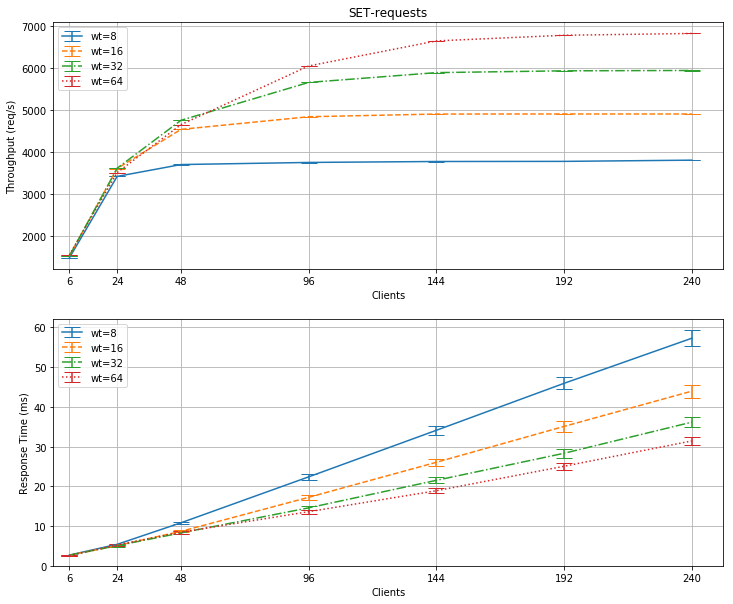

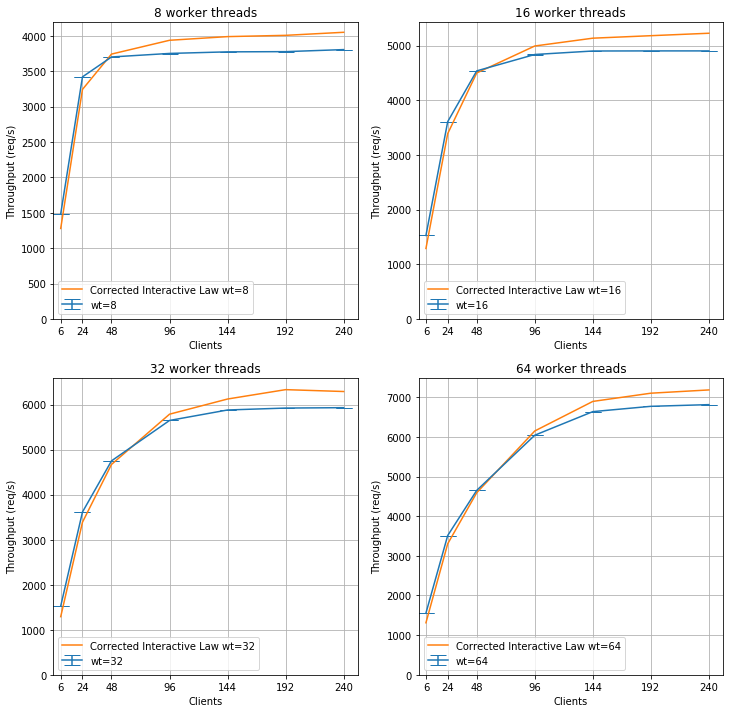

In [7]:
# GRAPH
from itertools import cycle
#Clients = #ClientVMs * MemtierPerVM * CT * VC
N_clients = np.multiply(3*2*1,vc)
X_axis = N_clients

lines = ["-","--","-.",":"]
linecycler = cycle(lines)

# Write to file
import distutils.dir_util
p = figure_path + "41_set_requests/"
distutils.dir_util.mkpath(p)
f = open(p+"processed.log", "w+")
f.write("X_axis\r\n")
f.write(str(X_axis))

# SET
figure2 = plt.figure(2, figsize=(12, 10))
figure2.add_subplot(2,1,1)
for i in xrange(len(set_mean_tp)):
    # plot
    graph = plt.errorbar(X_axis, np.multiply(wt[i],set_mean_tp[i]), yerr=set_stddev_tp[i], capsize=8, fmt=next(linecycler) , label="wt=" + str(wt[i]))
    f.write("\r\nset_mean_tp wt=" + str(wt[i])+"\r\n")
    f.write(str(np.multiply(wt[i],set_mean_tp[i])))
    f.write("\r\nset_std_tp wt=" + str(wt[i])+"\r\n")
    f.write(str(set_stddev_tp[i]))
    
plt.title("SET-requests")
plt.setp([plt.xticks(X_axis)])
plt.legend()
plt.grid(True)
plt.xlabel("Clients")
plt.ylabel("Throughput (req/s)")
#plt.ylim(0,4000)
plt.xlim(0)

figure2.add_subplot(2,1,2)
for i in xrange(len(set_mean_rt)):
    # plot
    graph = plt.errorbar(X_axis, set_mean_rt[i], yerr=set_stddev_rt[i], capsize=8, fmt=next(linecycler) , label="wt=" + str(wt[i]))
    f.write("\r\nset_mean_rt wt=" + str(wt[i])+"\r\n")
    f.write(str(set_mean_rt[i]))
    f.write("\r\nset_std_rt wt=" + str(wt[i])+"\r\n")
    f.write(str(set_stddev_rt[i]))
plt.setp([plt.xticks(X_axis)])
plt.legend()
plt.grid(True)
plt.xlabel("Clients")
plt.ylabel("Response Time (ms)")
plt.ylim(0)
plt.xlim(0)
figure2.savefig(figure_path+"41_set_requests.png")

f.close()

# Interactive Law
figure3 = plt.figure(3, figsize=(12, 12))

# Write to file
import distutils.dir_util
p = figure_path + "41_il/"
distutils.dir_util.mkpath(p)
f = open(p+"processed.log", "w+")
f.write("X_axis\r\n")
f.write(str(X_axis))

for i in xrange(4):
    figure3.add_subplot(2,2,i+1)
    graph = plt.errorbar(X_axis, np.multiply(wt[i],set_mean_tp[i]), yerr=set_stddev_tp[i], capsize=8 , label="wt=" + str(wt[i]))
    graph = plt.plot(X_axis, 1000*np.divide(N_clients,np.add(2,set_mean_rt[i])), label="Corrected Interactive Law wt="+str(wt[i]))
    plt.title(str(wt[i]) + " worker threads")
    plt.setp([plt.xticks(X_axis)])
    plt.legend()
    plt.grid(True)
    plt.xlabel("Clients")
    plt.ylabel("Throughput (req/s)")
    plt.ylim(0)
    plt.xlim(0)
    
    f.write("\r\nset_tp_mean wt="+str(wt[i])+"\r\n")
    f.write(str(np.multiply(wt[i],set_mean_tp[i])))
    f.write("\r\nset_tp_std wt="+str(wt[i])+"\r\n")
    f.write(str(set_stddev_tp[i]))
    f.write("\r\nset_tp_interactive_law_mean wt="+str(wt[i])+"\r\n")
    f.write(str(1000*np.divide(N_clients,np.add(2,set_mean_rt[i]))))
    
f.close()
figure3.savefig(figure_path+"41_il.png")